In [1]:
library(CellChat)
library(anndata)
library(patchwork)
options(stringsAsFactors = FALSE)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



In [2]:
ad <- read_h5ad("/home/wu/datb1/reseq_ppp/interaction_data/KC_IMMU_normalised_log_counts.h5ad")
# access count data matrix
counts <- t(as.matrix(ad$X))
data.input <- as(counts, "dgCMatrix")

# access meta data
meta <- ad$obs
meta$labels <- meta[["leiden"]] 
# save the data for CellChat analysis
# save(data.input, meta, file = "interaction_data/cellchat_data.RData")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”


In [3]:
meta$sample <- meta[['Meta']]

In [4]:
rm(counts)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4476923,239.1,8593361,459.0,6762543,361.2
Vcells,93821674,715.9,1339913388,10222.8,1480809353,11297.7


In [5]:
meta$leiden %>% table()

.
     Basal_Control_KC       Basal_Lesion_KC                  Immu 
                 8197                  2924                 16700 
Suprabasal_Control_KC  Suprabasal_Lesion_KC 
                 5863                  3374 

In [6]:
meta$labels %>% table()

.
     Basal_Control_KC       Basal_Lesion_KC                  Immu 
                 8197                  2924                 16700 
Suprabasal_Control_KC  Suprabasal_Lesion_KC 
                 5863                  3374 

In [7]:
control_subset <- meta$Meta == "Control"
lesion_subset <- meta$Meta == "Lesion"

In [8]:
control_data <- data.input[, control_subset]
lesion_data <- data.input[, lesion_subset]

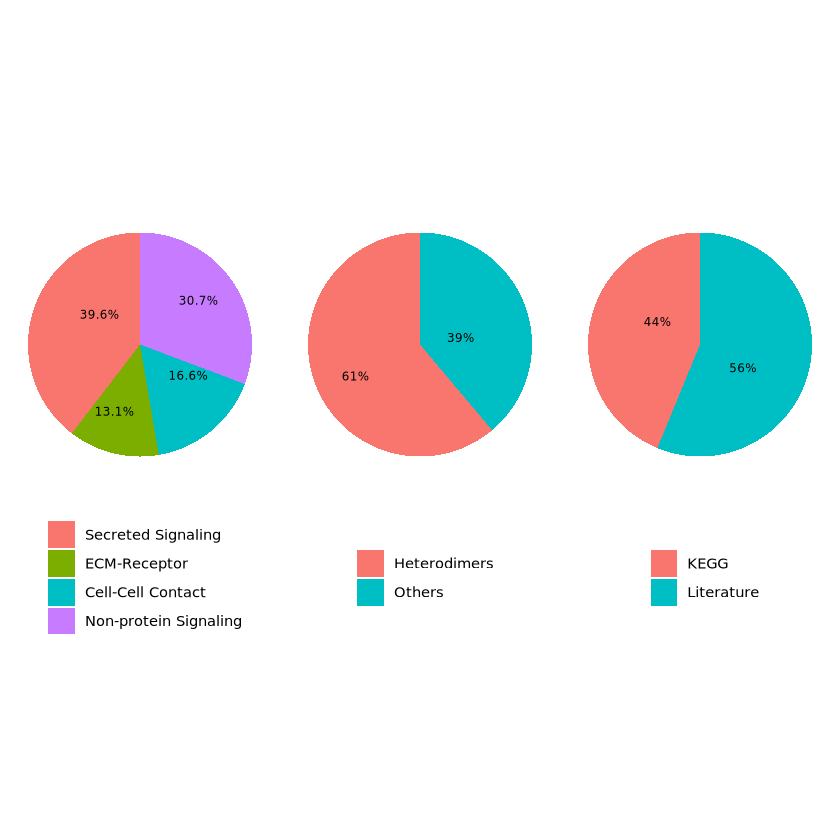

In [9]:
CellChatDB <- CellChatDB.human
showDatabaseCategory(CellChatDB)
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # use Secreted Signaling

In [10]:
meta$labels %>% table()

.
     Basal_Control_KC       Basal_Lesion_KC                  Immu 
                 8197                  2924                 16700 
Suprabasal_Control_KC  Suprabasal_Lesion_KC 
                 5863                  3374 

In [11]:
meta_control <- meta[control_subset,]
meta_control$labels <- droplevels(meta_control$labels, exclude = setdiff(levels(meta_control$labels),unique(meta_control$labels)))
cellchat_control <- createCellChat(object = control_data, meta = meta_control, group.by = "labels")

# use a subset of CellChatDB for cell-cell communication analysis

# set the used database in the object
cellchat_control@DB <- CellChatDB.use
# subset the expression data of signaling genes for saving computation cost
cellchat_control <- subsetData(cellchat_control) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) # do parallel
cellchat_control <- identifyOverExpressedGenes(cellchat_control)
cellchat_control <- identifyOverExpressedInteractions(cellchat_control)
#> The number of highly variable ligand-receptor pairs used for signaling inference is 621 
cellchat_control <- computeCommunProb(cellchat_control, type = "truncatedMean", trim = 0.05)

[1] "Create a CellChat object from a data matrix"


Warning message in createCellChat(object = control_data, meta = meta_control, group.by = "labels"):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Basal_Control_KC, Immu, Suprabasal_Control_KC 
The number of highly variable ligand-receptor pairs used for signaling inference is 603 
truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-05-27 12:03:43.42097]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-05-27 12:45:34.149294]"


In [12]:
cellchat_control <- filterCommunication(cellchat_control, min.cells = 50, nonFilter.keep = T)
cellchat_control <- computeCommunProbPathway(cellchat_control)
cellchat_control <- aggregateNet(cellchat_control)

The non-filtered cell-cell communication is stored in `object@net$prob.nonFilter` and `object@net$pval.nonFilter`. 


In [13]:
meta_lesion <- meta[lesion_subset,]
meta_lesion$labels <- droplevels(meta_lesion$labels, exclude = setdiff(levels(meta_lesion$labels),unique(meta_lesion$labels)))
cellchat_lesion <- createCellChat(object = lesion_data, meta = meta_lesion, group.by = "labels")

# use a subset of CellChatDB for cell-cell communication analysis

# set the used database in the object
cellchat_lesion@DB <- CellChatDB.use
# subset the expression data of signaling genes for saving computation cost
cellchat_lesion <- subsetData(cellchat_lesion) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) # do parallel
cellchat_lesion <- identifyOverExpressedGenes(cellchat_lesion)
cellchat_lesion <- identifyOverExpressedInteractions(cellchat_lesion)
#> The number of highly variable ligand-receptor pairs used for signaling inference is 692
cellchat_lesion <- computeCommunProb(cellchat_lesion, type = "truncatedMean", trim = 0.05)

[1] "Create a CellChat object from a data matrix"


Warning message in createCellChat(object = lesion_data, meta = meta_lesion, group.by = "labels"):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Basal_Lesion_KC, Immu, Suprabasal_Lesion_KC 
The number of highly variable ligand-receptor pairs used for signaling inference is 639 
truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-05-27 12:45:56.329133]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-05-27 13:49:08.588534]"


In [14]:
cellchat_lesion <- filterCommunication(cellchat_lesion, min.cells = 50)
cellchat_lesion <- computeCommunProbPathway(cellchat_lesion)
cellchat_lesion <- aggregateNet(cellchat_lesion)

In [15]:
saveRDS(cellchat_lesion, file = "/home/wu/datb1/reseq_ppp/interaction_results/cellchat_immu_kc_Lesion.rds")
saveRDS(cellchat_control, file = "/home/wu/datb1/reseq_ppp/interaction_results/cellchat_immu_kc_Control.rds")

In [16]:
rm(control_data, lesion_data)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4951186,264.5,8593361,459.0,8593361,459.0
Vcells,184553647,1408.1,548828525,4187.3,1480809353,11297.7


In [17]:
all_list <- list(cellchat_control, cellchat_lesion)
cellchat_all <- mergeCellChat(all_list, add.names = c("Control", "Lesion"), cell.prefix = TRUE)

Warning message in mergeCellChat(all_list, add.names = c("Control", "Lesion"), cell.prefix = TRUE):
“Prefix cell names!”


The cell barcodes in merged 'meta' is  PPPC_P38C2_palm_10X_AAACCCATCCGTATAG-1-KC PPPC_P38C2_palm_10X_AAACGAAAGGAAGTGA-1-KC PPPC_P38C2_palm_10X_AAACGAAGTATGGTTC-1-KC PPPC_P38C2_palm_10X_AAACGAAGTCGTTGCG-1-KC PPPC_P38C2_palm_10X_AAACGAAGTTGCGTAT-1-KC PPPC_P38C2_palm_10X_AAACGAATCCGAACGC-1-KC 


Warning message in mergeCellChat(all_list, add.names = c("Control", "Lesion"), cell.prefix = TRUE):
“The cell barcodes in merged 'meta' is different from those in the used data matrix.
              We now simply assign the colnames in the data matrix to the rownames of merged 'mata'!”
Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



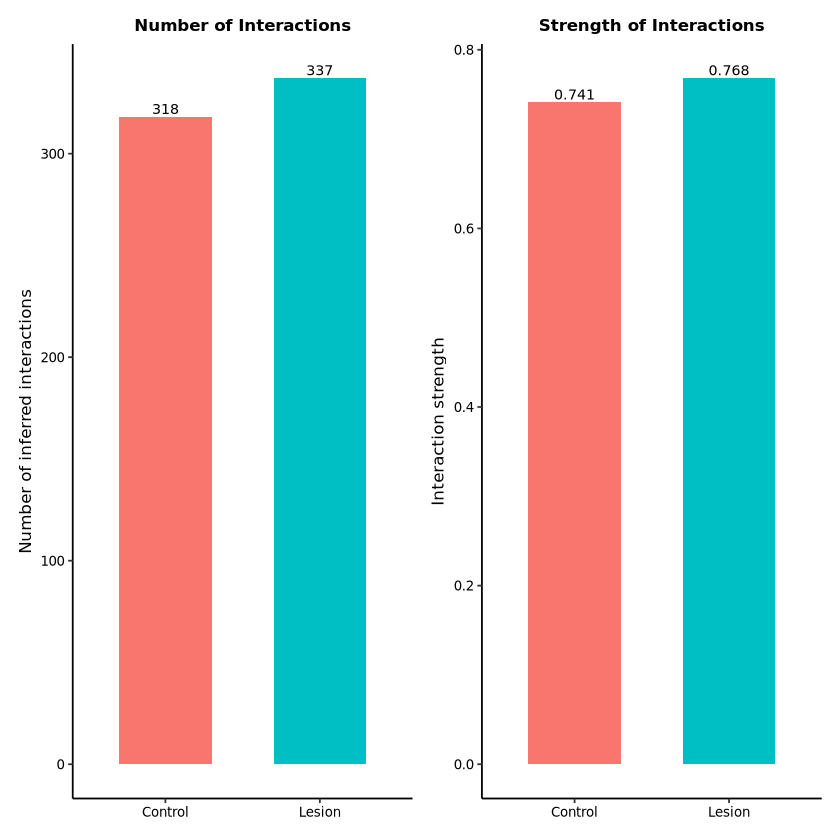

In [27]:
gg1 <- compareInteractions(cellchat_all, show.legend = F, group = c(1,2), measure = "count", title = "Number of Interactions")
gg2 <- compareInteractions(cellchat_all, show.legend = F, group = c(1,2), measure = "weight", title = "Strength of Interactions")
p <- gg1 + gg2
p
ggsave("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/Overview_number_strength.pdf", p, width = 5, height = 4)

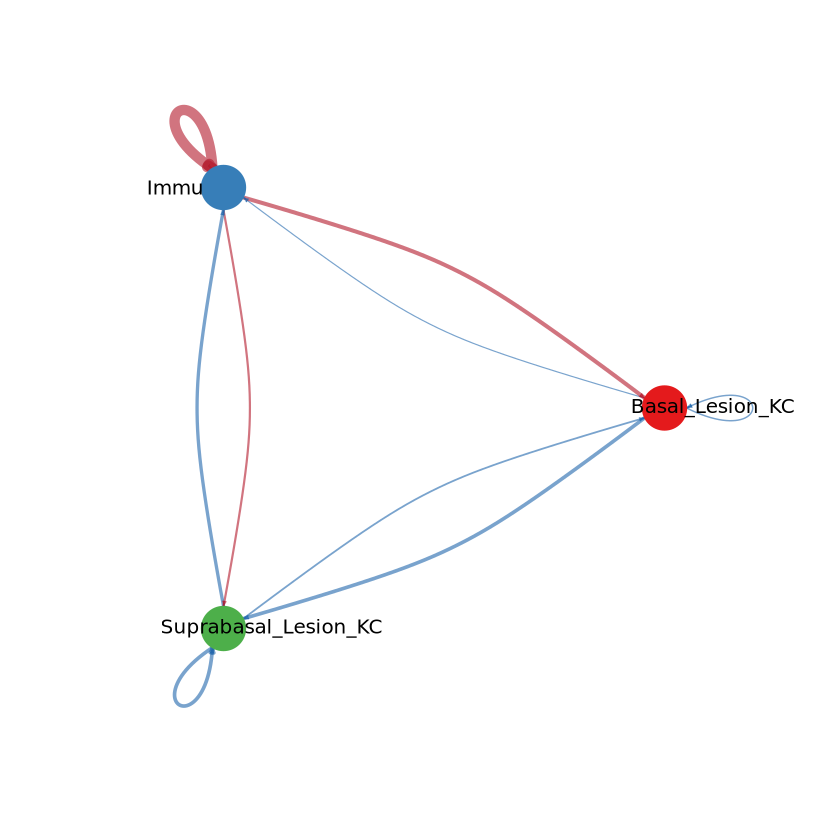

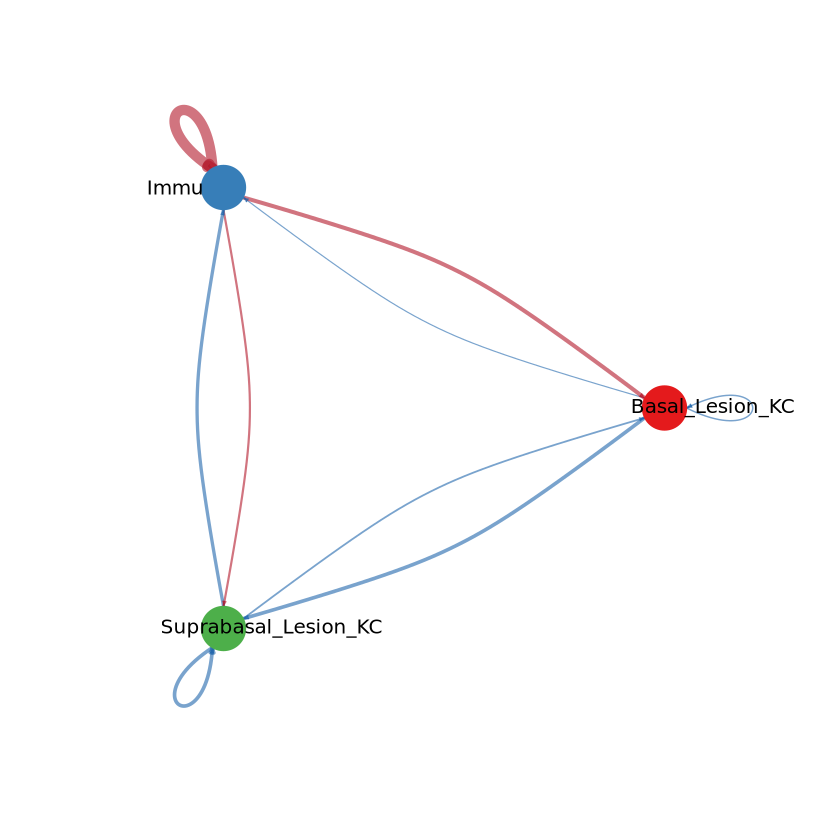

In [19]:
netVisual_diffInteraction(cellchat_all, weight.scale = T, measure = "weight")

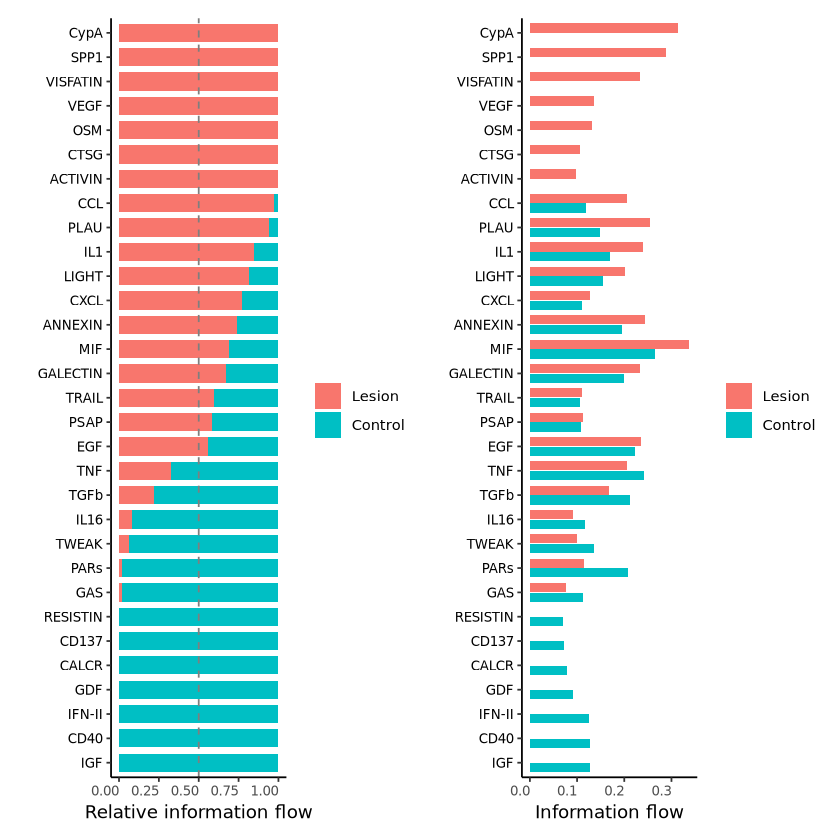

In [20]:
gg1 <- rankNet(cellchat_all, mode = "comparison", stacked = T, do.stat = TRUE, comparison = c(2, 1), sources.use = 2, cutoff.pvalue = 0.00) # color.use
gg2 <- rankNet(cellchat_all, mode = "comparison", stacked = F, do.stat = TRUE, comparison = c(2, 1), sources.use = 2, cutoff.pvalue = 0.00) # color.use
p <- gg1 + gg2
p
ggsave("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/Overview_ranknet_comparison.pdf", p, width = 6.5, height = 5.5)

In [21]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()        masks igraph::%--%()
✖ tibble::as_data_frame()  masks igraph::as_data_frame(), dplyr::as_data_frame()
✖ Biobase::combine()       masks BiocGenerics::combine(), dplyr::combine()
✖ purrr::compose()         masks igraph::compose()
✖ tidyr::crossing()        masks igraph::crossing()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::lag()             masks stats::lag()
✖ BiocGenerics::Position() masks ggplot2::Position(), base::Position()
✖ readr::read_csv()        masks anndata::read_csv()
✖ purrr::simplify()        masks igraph::simplify()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [28]:
ipa_tbl <- read_tsv("/home/wu/datb1/reseq_ppp/Pub_PPP_code/charts/IPA_cytokine_kc_upstream.txt", skip = 2)
input_list <- ipa_tbl %>% filter(`Predicted Activation State` == "Activated") %>% select(`Upstream Regulator`) %>% unique() 

Rows: 122 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Upstream Regulator, Molecule Type, Predicted Activation State, Flag...
dbl (3): Expr Log Ratio, Activation z-score, p-value of overlap

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [29]:
lr_include = CellChatDB.use$interaction$interaction_name[CellChatDB.use$interaction$ligand %in% input_list$`Upstream Regulator`]

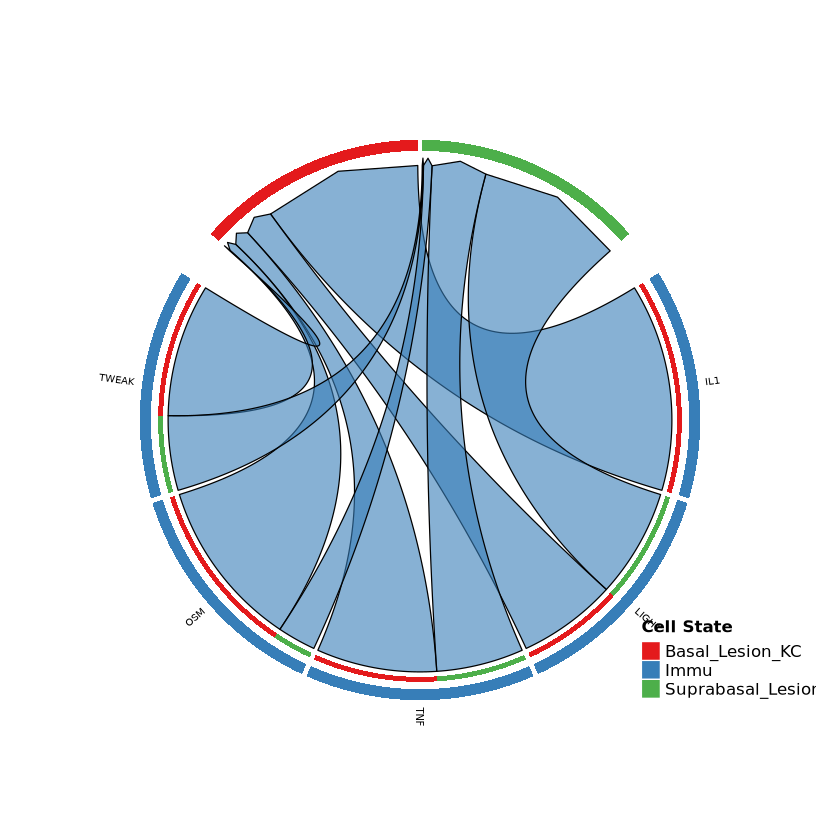

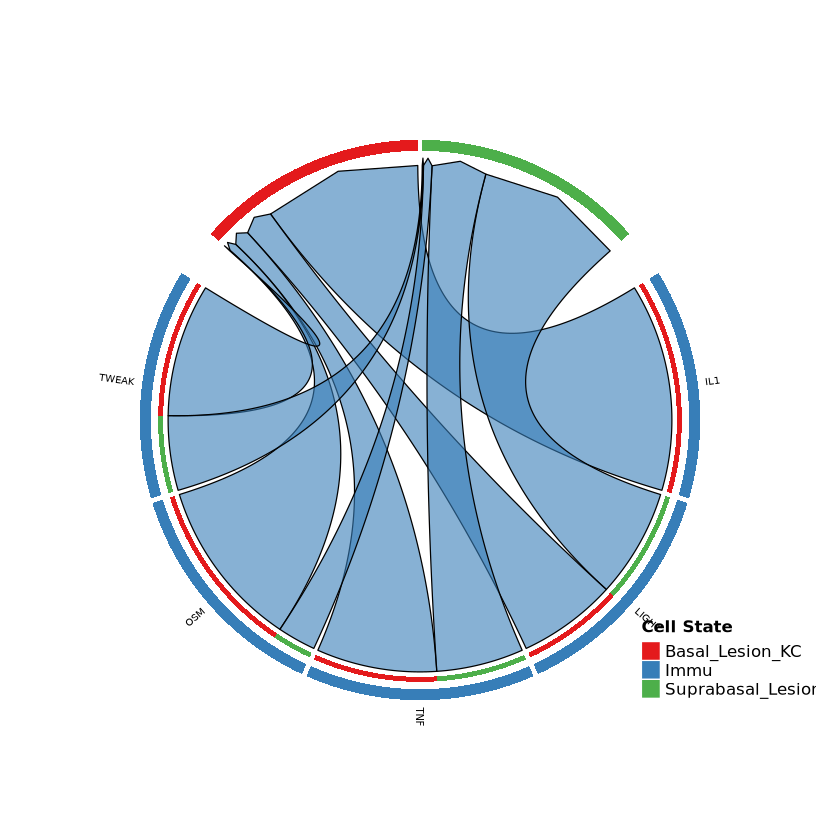

In [30]:
netVisual_chord_gene(cellchat_lesion, sources.use = 2, targets.use = c(1,3), slot.name = "netP", legend.pos.x = 0, pairLR.use = data.frame(interaction_name = lr_include), scale = T, link.border= T, lab.cex = 0.5, legend.pos.y = 30)

In [31]:
# save the plot as pdf
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_immu_kc_Control.pdf", width = 6, height = 6)
a = netVisual_chord_gene(cellchat_control,
                     sources.use = c(2), targets.use = c(1,3),
                     scale = T,
                     slot.name = "netP",
                     title.name = 'Control',
                     link.target.prop = T,
                     pairLR.use = data.frame(interaction_name = lr_include),
                     lab.cex = 0.5, legend.pos.x = 5, legend.pos.y = 10)
dev.off()

png 
  2

In [32]:
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_immu_kc_Lesion.pdf", width = 6, height = 6)
a = netVisual_chord_gene(cellchat_lesion,
                     sources.use = c(2), targets.use = c(1,3),
                     scale = T,
                     slot.name = "netP",
                     title.name = 'Lesion',
                     link.target.prop = T,
                     pairLR.use = data.frame(interaction_name = lr_include),
                     lab.cex = 0.5, legend.pos.x = 5, legend.pos.y = 10)
dev.off()

png 
  2